# Setup 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

In [34]:
X, y = datasets.make_blobs(n_samples = 100, random_state = 10)

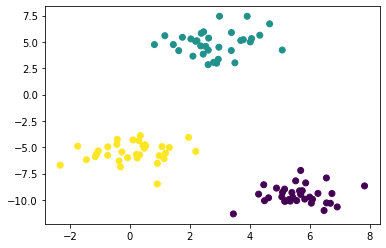

In [37]:
plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

# Decision tree 

Splitting the training set in a way that produces the purest subsets.

Gini impurity

$$
G_{i} = 1 - \sum_{k=1}^{m} p_{i,k}^{2}
$$